In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
import importlib
import GModReLU as GModReLUMod
importlib.reload(GModReLUMod)
from GModReLU import GModReLU, GModReLUFunction, LGRLinear,LGRConv2d

In [3]:
dtype = torch.float
device = torch.device("cpu")

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define transform
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

full_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

from torch.utils.data import random_split

# Split into train and val
train_size = int(0.9 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class CNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super().__init__()
        self.activation = activation_fn

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
import torch.nn as nn

class LGRCNN(nn.Module):
    def __init__(self, l=0.01, k=5.0):
        super().__init__()
        
        self.conv1 = LGRConv2d(3, 32, kernel_size=3, padding=1, l=l, k=k)
        self.conv2 = LGRConv2d(32, 64, kernel_size=3, padding=1, l=l, k=k)
        self.conv3 = LGRConv2d(64, 128, kernel_size=3, padding=1, l=l, k=k)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = LGRLinear(128 * 4 * 4, 128, l=l, k=k)
        self.fc2 = nn.Linear(128, 10)  # Final layer can stay standard (no modulation)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [7]:
from ResNet import ResNet18

In [8]:
import LGRResNet
importlib.reload(LGRResNet)
from LGRResNet import LGRResNet18

In [9]:
import importlib
import Train
importlib.reload(Train)
from Train import train_and_evaluate, validate_model

In [10]:
log_data = dict()
model_data = dict()
def insert_log_data(key,data):
    if key not in log_data:
        log_data[key] = []
    log_data[key].append(data)
def insert_model_data(key,data):
    if key not in log_data:
        model_data[key] = []
    model_data[key].append(data)

In [1]:
import load_log_data from FileUtils

SyntaxError: Did you mean to use 'from ... import ...' instead? (4049698542.py, line 1)

In [29]:
l = 0.01
k = 5.0
lgr_log, lgr_model = train_and_evaluate(
    network = LGRCNN(l = l, k = k),
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=5,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("lgr",l,k),lgr_log)

Epoch 1/5 | Train Loss: 1.5241 | Train Acc: 44.41% | Val Acc: 55.96%


Epoch 2/5 | Train Loss: 1.1141 | Train Acc: 60.33% | Val Acc: 60.48%


Epoch 3/5 | Train Loss: 0.9341 | Train Acc: 66.98% | Val Acc: 66.72%


Epoch 4/5 | Train Loss: 0.8291 | Train Acc: 70.92% | Val Acc: 72.02%


Epoch 5/5 | Train Loss: 0.7575 | Train Acc: 73.30% | Val Acc: 73.24%


NameError: name 'log' is not defined

In [30]:
insert_log_data(("lgr",l,k),lgr_log)

In [28]:
# Testing the new LGR method
logs_gmodrelus = [] 
k_vals = np.linspace(0,0.01,4)
for i in range(k_vals.shape[0]):
    log, model = train_and_evaluate(
        network = LGRCNN(),
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=5,          # or however many you want
        lr=0.001,           # or your preferred LR
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    insert_log_data(("",0.01,k_vals[i]),log)
    logs_gmodrelus.append(log)

KeyboardInterrupt: 

In [ ]:
# Testing to find the tuned k_val value in a non-scaling kernel
logs_gmodrelus = [] 
k_vals = np.linspace(0,0.01,4)
for i in range(k_vals.shape[0]):
    log, model = train_and_evaluate(
        GModReLU(l=0.01,k=k_vals[i],kernel_type = "noscale"),
        network_class = CNN,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=5,          # or however many you want
        lr=0.001,           # or your preferred LR
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    insert_log_data(("gmodrelu:noscale",0.01,k_vals[i]),log)
    logs_gmodrelus.append(log)

In [15]:
 relu_log, relu_model = train_and_evaluate(
        network = CNN(),
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=5,          # or however many you want
        lr=0.001,           # or your preferred LR
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

Epoch 1/5 | Train Loss: 1.5434 | Train Acc: 43.70% | Val Acc: 55.28%


Epoch 2/5 | Train Loss: 1.1686 | Train Acc: 58.31% | Val Acc: 60.86%


Epoch 3/5 | Train Loss: 1.0138 | Train Acc: 64.22% | Val Acc: 66.48%


Epoch 4/5 | Train Loss: 0.9125 | Train Acc: 67.56% | Val Acc: 67.46%


Epoch 5/5 | Train Loss: 0.8405 | Train Acc: 70.54% | Val Acc: 69.68%


In [330]:
# Testing to find the tuned l_val value in a non-scaling kernel
logs_gmodrelus = [] 
l_vals = np.linspace(0.001,0.015,3)
for i in range(l_vals.shape[0]):
    l_val = l_vals[i]
    k_val = 0.01
    log, model = train_and_evaluate(
        GModReLU(l=l_val,k=k_val,kernel_type = "noscale"),
        network_class = CNN,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=5,          # or however many you want
        lr=0.001,           # or your preferred LR
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    insert_log_data(("gmodrelu:noscale",l_val,k_val),log)
    logs_gmodrelus.append(log)

Epoch 1/5 | Train Loss: 1.5257 | Train Acc: 43.86% | Val Acc: 54.50%


Epoch 2/5 | Train Loss: 1.1161 | Train Acc: 60.18% | Val Acc: 62.38%


Epoch 3/5 | Train Loss: 0.9504 | Train Acc: 66.47% | Val Acc: 68.12%


Epoch 4/5 | Train Loss: 0.8487 | Train Acc: 70.25% | Val Acc: 69.38%


Epoch 5/5 | Train Loss: 0.7850 | Train Acc: 72.30% | Val Acc: 71.46%


KeyboardInterrupt: 

In [17]:
import pickle
with open('log_data_comparing_activations.pkl', 'rb') as file: 
    # Call load method to deserialze 
    log_data = pickle.load(file) 

In [349]:

with open('log_data_comparing_activations.pkl', 'wb') as file: 
    # A new file will be created 
    pickle.dump(log_data, file) 

In [339]:
#Testing to see if noscalefixed performs differently to noscale
noscalefixed_log, noscalefixed_model = train_and_evaluate(
    GModReLU(l=0.01,k=0.01,kernel_type = "noscalefixed"),
    network_class = CNN,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=5,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Epoch 1/5 | Train Loss: 1.4967 | Train Acc: 45.23% | Val Acc: 56.92%


Epoch 2/5 | Train Loss: 1.0791 | Train Acc: 61.51% | Val Acc: 65.02%


Epoch 3/5 | Train Loss: 0.9108 | Train Acc: 67.85% | Val Acc: 69.06%


Epoch 4/5 | Train Loss: 0.8192 | Train Acc: 71.14% | Val Acc: 72.32%


Epoch 5/5 | Train Loss: 0.7572 | Train Acc: 73.44% | Val Acc: 72.18%


In [19]:
from Figures import log_data_with_k, plot_logs_k, plot_logs_ke, log_data_with_l

In [20]:
log_data_with_l(0.01,log_data, "gmodrelu:noscale")[0][0].keys()

dict_keys(['batches', 'train_loss', 'train_acc', 'train_grad_norm', 'train_weight_update_norm', 'val_loss', 'val_acc', 1, 'train_weight_udpdate_norm'])

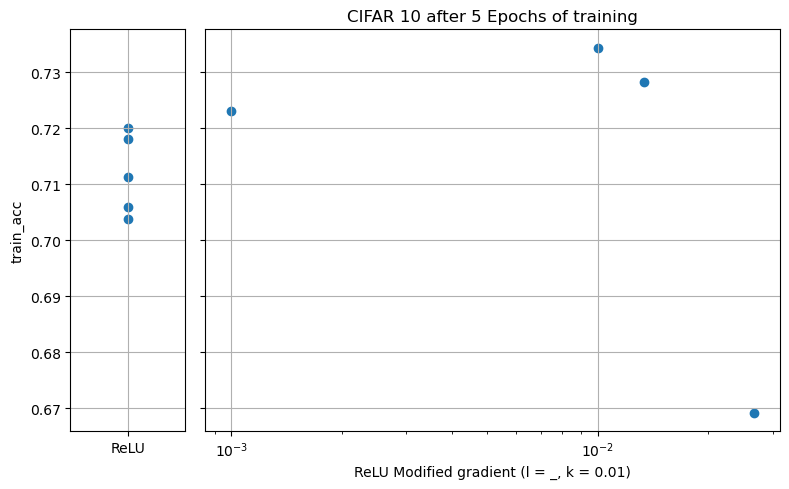

In [22]:
#Visualise performance of no-scale gmodrelu after 5 epochs
relu_log_entries = log_data[('gmodrelu:noscale', 0.01, 0.0)]
prop = "train_acc"
plot_logs_ke(*log_data_with_k(0.01,log_data, "gmodrelu:noscale"),prop = prop, x_axis = 'epoch',
             index = 4,
             i_cut = 100,
              baselines=[["ReLU"]*len(relu_log_entries),relu_log_entries],
                  title = f"CIFAR 10 after 5 Epochs of training",
                 x_label = "ReLU Modified gradient (l = _, k = 0.01)",
                 x_scale = "log",
                )

In [35]:
log_data.keys()

dict_keys([('gmodrelu:noscale', 0.01, 0.0), ('gmodrelu:noscale', 0.01, 0.03), ('gmodrelu:noscale', 0.01, 0.06), ('gmodrelu:noscale', 0.01, 0.09), ('gmodrelu:noscale', 0.01, 0.12), ('gmodrelu:noscale', 0.01, 0.15), ('gmodrelu:noscale', 0.01, 0.0125), ('gmodrelu:noscale', 0.01, 0.025), ('gmodrelu:noscale', 0.01, 0.037500000000000006), ('gmodrelu:noscale', 0.01, 0.05), ('gmodrelu:noscale', 0.01, 0.00375), ('gmodrelu:noscale', 0.01, 0.0075), ('gmodrelu:noscale', 0.01, 0.01125), ('gmodrelu:noscale', 0.01, 0.015), ('gmodrelu:noscale', 0.01, 0.0025), ('gmodrelu:noscale', 0.01, 0.005), ('gmodrelu:noscale', 0.01, 0.1), ('gmodrelu:noscale', 0.01, 0.7999999999999999), ('gmodrelu:noscale', 0.01, 1.5), ('gmodrelu:noscale', 0.01, 0.0033333333333333335), ('gmodrelu:noscale', 0.01, 0.006666666666666667), ('gmodrelu:noscale', 0.01, 0.01), ('gmodrelu:noscale', 0.0, 0.01), ('gmodrelu:noscale', 0.013333333333333334, 0.01), ('gmodrelu:noscale', 0.02666666666666667, 0.01), ('gmodrelu:noscale', 0.001, 0.01),

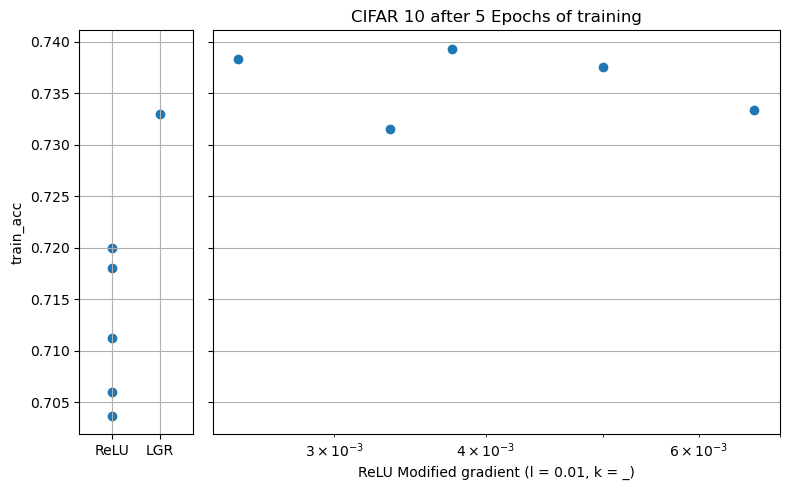

In [42]:
relu_log_entries = log_data[('gmodrelu:noscale', 0.01, 0.0)]
lgr_log_entries = log_data[("lgr",l,k)]
prop = "train_acc"
plot_logs_ke(*log_data_with_l(0.01,log_data, "gmodrelu:noscale"),prop = prop, x_axis = 'epoch',
             index = 4,
             i_cut = 10,
              baselines=[["ReLU"]*len(relu_log_entries) + ["LGR"]*len(lgr_log_entries),relu_log_entries + lgr_log_entries ],
                  title = f"CIFAR 10 after 5 Epochs of training",
                 x_label = "ReLU Modified gradient (l = 0.01, k = _)",
                 x_scale = "log",
                )

In [223]:
noscale_model_log, noscale_model = train_and_evaluate(
            GModReLU(l=0.01,k=0.1, kernel_type = "noscale"),
            network_class = CNN,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=10,          # or however many you want
            lr=0.001,           # or your preferred LR
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

KeyboardInterrupt: 

In [222]:

noscale_model_log, noscale_model = train_and_evaluate(
            GModReLU(l=0.01,k=0.1, kernel_type = "noscale"),
            network_class = CNN,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=10,          # or however many you want
            lr=0.001,           # or your preferred LR
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

Epoch 1/10 | Train Loss: 1.5112 | Train Acc: 44.63% | Val Acc: 55.22%


Epoch 2/10 | Train Loss: 1.1028 | Train Acc: 60.57% | Val Acc: 63.34%


Epoch 3/10 | Train Loss: 0.9536 | Train Acc: 66.49% | Val Acc: 62.34%


Epoch 4/10 | Train Loss: 0.8664 | Train Acc: 69.46% | Val Acc: 72.08%


Epoch 5/10 | Train Loss: 0.8167 | Train Acc: 71.39% | Val Acc: 67.70%


Epoch 6/10 | Train Loss: 0.7813 | Train Acc: 72.70% | Val Acc: 67.16%


Epoch 7/10 | Train Loss: 0.7616 | Train Acc: 73.21% | Val Acc: 70.50%


Epoch 8/10 | Train Loss: 0.7441 | Train Acc: 74.07% | Val Acc: 74.00%


Epoch 9/10 | Train Loss: 0.7227 | Train Acc: 74.86% | Val Acc: 74.52%


Epoch 10/10 | Train Loss: 0.7086 | Train Acc: 75.31% | Val Acc: 69.94%


In [225]:
fixed_model_log, fixed_model = train_and_evaluate(
            GModReLU(l=0.01,k=0.001, kernel_type = "fixed"),
            network_class = CNN,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=10,          # or however many you want
            lr=0.001,           # or your preferred LR
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

Epoch 1/10 | Train Loss: 1.5574 | Train Acc: 42.82% | Val Acc: 51.96%


Epoch 2/10 | Train Loss: 1.1720 | Train Acc: 57.90% | Val Acc: 61.32%


Epoch 3/10 | Train Loss: 0.9959 | Train Acc: 64.73% | Val Acc: 65.90%


Epoch 4/10 | Train Loss: 0.8943 | Train Acc: 68.62% | Val Acc: 70.06%


Epoch 5/10 | Train Loss: 0.8280 | Train Acc: 70.91% | Val Acc: 71.88%


Epoch 6/10 | Train Loss: 0.7697 | Train Acc: 72.86% | Val Acc: 67.68%


Epoch 7/10 | Train Loss: 0.7287 | Train Acc: 74.44% | Val Acc: 73.30%


Epoch 8/10 | Train Loss: 0.7008 | Train Acc: 75.39% | Val Acc: 74.70%


Epoch 9/10 | Train Loss: 0.6711 | Train Acc: 76.65% | Val Acc: 74.04%


Epoch 10/10 | Train Loss: 0.6467 | Train Acc: 77.17% | Val Acc: 75.34%


In [178]:
relu_model_log, relu_model = train_and_evaluate(
            GModReLU(l=0.00,k=0.001),
            network_class = CNN,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=10,          # or however many you want
            lr=0.001,           # or your preferred LR
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

Epoch 1/10 | Train Loss: 1.5455 | Train Acc: 43.55% | Val Acc: 52.70%


Epoch 2/10 | Train Loss: 1.1590 | Train Acc: 58.55% | Val Acc: 61.58%


Epoch 3/10 | Train Loss: 0.9774 | Train Acc: 65.44% | Val Acc: 65.62%


Epoch 4/10 | Train Loss: 0.8782 | Train Acc: 69.10% | Val Acc: 69.90%


Epoch 5/10 | Train Loss: 0.8102 | Train Acc: 71.49% | Val Acc: 70.86%


Epoch 6/10 | Train Loss: 0.7677 | Train Acc: 73.13% | Val Acc: 72.46%


Epoch 7/10 | Train Loss: 0.7209 | Train Acc: 74.82% | Val Acc: 73.98%


Epoch 8/10 | Train Loss: 0.6847 | Train Acc: 75.89% | Val Acc: 74.30%


Epoch 9/10 | Train Loss: 0.6627 | Train Acc: 76.98% | Val Acc: 74.06%


Epoch 10/10 | Train Loss: 0.6439 | Train Acc: 77.44% | Val Acc: 73.44%


In [180]:
torch.save(relu_model.state_dict(),"relu_model.pth")

In [181]:
exploding_model_log, exploding_model = train_and_evaluate(
            GModReLU(l=0.07,k=0.001),
            network_class = CNN,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=10,          # or however many you want
            lr=0.001,           # or your preferred LR
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )


Epoch 1/10 | Train Loss: 1.5537 | Train Acc: 43.01% | Val Acc: 46.22%


Epoch 2/10 | Train Loss: 1.2765 | Train Acc: 54.54% | Val Acc: 52.32%


Epoch 3/10 | Train Loss: 1.1903 | Train Acc: 57.98% | Val Acc: 57.50%


Epoch 4/10 | Train Loss: 1.1388 | Train Acc: 60.02% | Val Acc: 60.14%


Epoch 5/10 | Train Loss: 1.1011 | Train Acc: 61.24% | Val Acc: 58.52%


Epoch 6/10 | Train Loss: 1.0783 | Train Acc: 62.48% | Val Acc: 58.24%


Epoch 7/10 | Train Loss: 1.0533 | Train Acc: 63.33% | Val Acc: 59.10%


Epoch 8/10 | Train Loss: 1.0478 | Train Acc: 63.57% | Val Acc: 60.46%


Epoch 9/10 | Train Loss: 1.0331 | Train Acc: 63.81% | Val Acc: 57.88%


Epoch 10/10 | Train Loss: 1.0291 | Train Acc: 64.19% | Val Acc: 61.58%


In [182]:
torch.save(exploding_model.state_dict(),"exploding_model.pth")

In [227]:
validate_model(fixed_model,val_loader, "cpu")

(0.7124848443984986, 0.753)

In [228]:
validate_model(stable_model,val_loader, "cpu")

(0.6787660021781922, 0.7676)

In [229]:
validate_model(relu_model,val_loader, "cpu")

(0.737129284286499, 0.7458)

In [231]:
validate_model(noscale_model,val_loader, "cpu")

(0.8566365886688232, 0.699)

In [179]:
Relu model: l = 0
Stable model: l = 0.01
Unstable model: l = 0.04...
Exploding model: l = 


SyntaxError: invalid syntax (2594606354.py, line 1)

In [177]:
validate_model(unstable_model,val_loader, "cpu")

(0.7171083753108978, 0.7484)

In [174]:
torch.save(stable_model.state_dict(),"stable_model.pth")

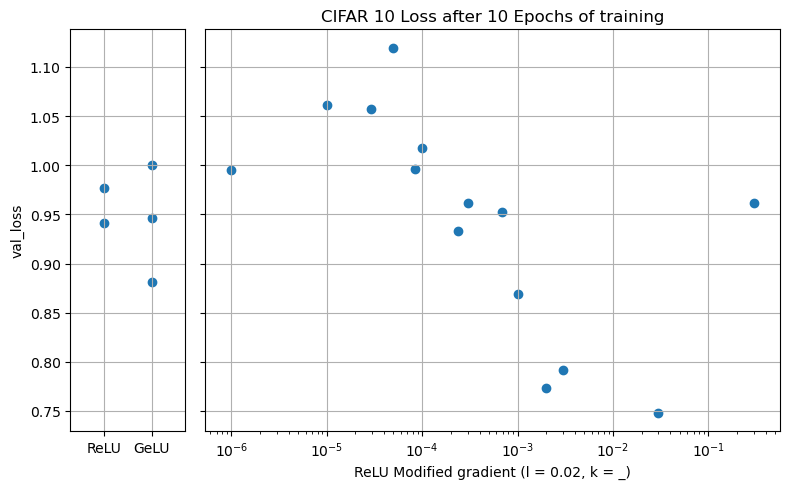

In [994]:
plot_logs_ke(*log_data_with_k(0.001),prop = prop, x_axis = 'epoch', i_cut = 39,
                  baselines=[["ReLU","ReLU","GeLU","GeLU","GeLU"],[*log_data[('gmodrelu', 0.02, 0.0)],*log_data['gelu']]],
                  title = f"CIFAR 10 {desc} after 10 Epochs of training",
                 x_label = "ReLU Modified gradient (l = _, k = 0.001)",
                 x_scale = "linear",
                 file_name = f"cifar_l_full_{prop}"
                )

2.0

In [145]:
from tqdm import tqdm

In [153]:
def get_gradient_statistics(model):
    model.train()
    grad_norms = []
    criterion = torch.nn.CrossEntropyLoss()
    pbar = tqdm(train_loader, desc=f"Training data", leave=False)
    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        total_norm = 0;
        # Gradients and updates
        for p in model.parameters():
            if p.grad is not None:
                total_norm += p.grad.data.norm(2).item() ** 2
        grad_norms.append(math.sqrt(total_norm))
    return np.average(grad_norms)

In [13]:
inputs, labels = next(iter(train_loader))

In [14]:
def probe_gradients(model,module,layer = "conv1", side = "output"):
    activation = {}
    gradient = {}
    def get_activation(name, side = "output"):
        def hook(model, input, output):
            print("get activation hook",type(input),type(output))
            if side == "output":
                activation[name] = output
            else:
                activation[name] = input
        return hook
    def get_gradient(name, side = "output"):
        def hook(model, input, output):
            print("get gradient hook",type(input),len(input),type(output),len(output))
            if side == "output":
                gradient[name] = output
            else:
                gradient[name] = input
        return hook
    hooks = []
    hooks.append(module.register_forward_hook(get_activation("conv1", side)))
    hooks.append(module.register_backward_hook(get_gradient("conv1", side)))
    criterion = torch.nn.CrossEntropyLoss()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    
    for hook in hooks:
        hook.remove()
    return gradient['conv1'], activation['conv1']

In [133]:
relu_model =  CNN(GModReLU(l=0.00,k= 0.001))
relu_model.load_state_dict(torch.load('relu_model.pth', weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [200]:
ko_model =  CNN(GModReLU(l=0.0,k= 0.001))
ko_model.load_state_dict(torch.load('exploding_model.pth', weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [118]:
def probe_fc_layers(model):
    fc2_inputs = [*probe_gradients(model,model.fc2, side = "input")]
    fc1_outputs = [*probe_gradients(model,model.fc1)]
    fc1_output_grad = fc1_outputs[0][0]
    fc1_output_val = fc1_outputs[1]
    fc2_input_grad = fc2_inputs[0][1]
    fc2_input_val = fc2_inputs[1][0]
    return fc1_output_grad, fc1_output_val, fc2_input_grad

In [188]:
fc1_grad, fc1_val, fc2_grad = probe_fc_layers(exploding_model)
fc1_val = fc1_val.detach()

get activation hook <class 'tuple'> <class 'torch.Tensor'>
get gradient hook <class 'tuple'> 3 <class 'tuple'> 1
get activation hook <class 'tuple'> <class 'torch.Tensor'>
get gradient hook <class 'tuple'> 3 <class 'tuple'> 1


In [203]:
relu_fc1_grad, relu_fc1_val, relu_fc2_grad  =probe_fc_layers(relu_model)
relu_fc1_val = relu_fc1_val.detach()

get activation hook <class 'tuple'> <class 'torch.Tensor'>
get gradient hook <class 'tuple'> 3 <class 'tuple'> 1
get activation hook <class 'tuple'> <class 'torch.Tensor'>
get gradient hook <class 'tuple'> 3 <class 'tuple'> 1


In [137]:
fc1_grad.std()/relu_fc1_grad.std()

tensor(0.9989)

In [183]:
relu_grad_norm = get_gradient_statistics(relu_model)

In [184]:
exploding_grad_norm =  get_gradient_statistics(exploding_model)

In [187]:
exploding_grad_norm/relu_grad_norm

21.41098630360933

In [205]:
relu_fc1_grad.std()/relu_fc2_grad.std()

tensor(0.6029)

In [208]:
(relu_fc1_grad.std(),fc1_grad.std())

(tensor(0.0004), tensor(0.0038))

In [209]:
(relu_fc2_grad.std(),fc2_grad.std())

(tensor(0.0007), tensor(0.0040))

In [207]:
(relu_fc1_val.std(),fc1_val.std())

(tensor(3.1776), tensor(0.1335))

(array([2.000e+00, 6.000e+00, 2.300e+01, 1.400e+02, 1.740e+03, 4.140e+03,
        1.806e+03, 2.800e+02, 4.500e+01, 1.000e+01]),
 array([-0.77646863, -0.61371249, -0.45095631, -0.28820017, -0.12544401,
         0.03731215,  0.20006831,  0.36282447,  0.52558064,  0.68833679,
         0.85109293]),
 <BarContainer object of 10 artists>)

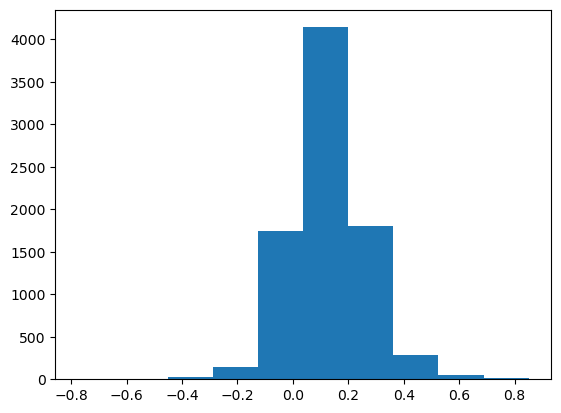

In [212]:
plt.hist(torch.flatten(fc1_val))

In [328]:
print(list(exploding_models.keys())[1])
stable_model_grads = [ 
    probe_gradients(stable_model,stable_model.conv1),
    probe_gradients(stable_model,stable_model.fc1),
    probe_gradients(stable_model,stable_model.fc2, side = "input"),
    probe_gradients(stable_model,stable_model.fc2),
]
unstable_model_grads = [ 
    probe_gradients(unstable_model,unstable_model.conv1),
    probe_gradients(unstable_model,unstable_model.fc1),
    probe_gradients(unstable_model,unstable_model.fc2, side = "input"),
    probe_gradients(unstable_model,unstable_model.fc2),
]
    

('gmodrelu:hyperbolic', 0.015874010519682007, 0.001)


In [256]:
stable_model_grads[1].norm()/stable_model_grads[2].norm()

tensor(0.5195)

In [251]:
stable_model_grads[1].max()

tensor(0.0063)

In [ ]:
class CNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super().__init__()
        self.activation = activation_fn

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x